In [1]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB 660.6 kB/s eta 0:02:34
   ---------------------------------------- 0.2/101.7 MB 1.9 MB/s eta 0:00:55
   ---------------------------------------- 0.5/101.7 MB 3.7 MB/s eta 0:00:28
   ---------------------------------------- 0.8/101.7 MB 4.9 MB/s eta 0:00:21
   ---------------------------------------- 1.2/101.7 MB 4.9 MB/s eta 0:00:21
    --------------------------------------- 1.5/101.7 MB 5.5 MB/s eta 0:00:19
    --------------------------------------- 1.8/101.7 MB 5.8 MB/s eta 0:00:18
    --------------------------------------- 2.2/101.7 MB 5.7 MB/s eta 0:00:18
   - -------------------------------------- 2.6/101.7 MB 6.1 MB/s eta 0:00:17
   - -------------------------------------- 2.9/101.7 MB 6.4 MB/s eta 0:00:16
   - -------------------------------------- 3.1/101.7 MB 6.2 MB/s eta

In [1]:
import numpy as np 
import pandas as pd 
from catboost import CatBoostRegressor, Pool 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR 
from sklearn.kernel_ridge import KernelRidge 
import matplotlib.pyplot as plt 
import seaborn as sns

In [6]:
!pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import opendatasets as od 

In [9]:
od.download( 
    "https://www.kaggle.com/c/LANL-Earthquake-Prediction/data?select=test") 

100%|█████████████████████████████████████████████████████████████████████████████| 2.27G/2.27G [07:59<00:00, 5.09MB/s]



Extracting archive .\LANL-Earthquake-Prediction/LANL-Earthquake-Prediction.zip to .\LANL-Earthquake-Prediction


In [7]:
train = pd.read_csv('LANL-Earthquake-Prediction/train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})     

In [8]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


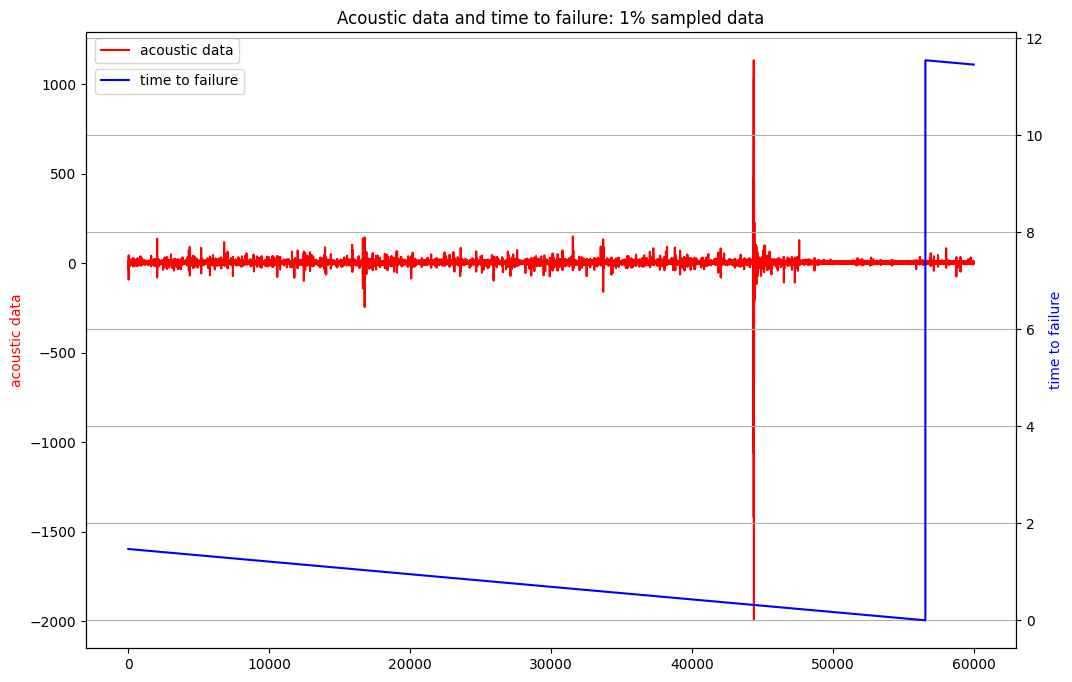

In [9]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

### Thus we can clearly see that the just before the time to failure and spike in acoustic data happens. Right before the vertical blue line, there is a spike in earthquake activity. Thus, we find our pattern

# Feature Engineering 

In [15]:
# Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data

def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain) 

In [21]:
train = pd.read_csv('LANL-Earthquake-Prediction/train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()

for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = pd.concat([X_train, ch], ignore_index=True)
    
    # Repeat the label for each row of features generated
    num_rows = len(ch)
    label = pd.Series([df['time_to_failure'].values[-1]] * num_rows)
    y_train = pd.concat([y_train, label], ignore_index=True)


C:\Users\ASIF-PC\AppData\Local\Temp\ipykernel_6596\700737761.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_train = pd.concat([y_train, label], ignore_index=True)


In [18]:
X_train.describe()

,0
count,54535.000000
mean,22.562341
std,155.697506
min,-5515.000000
25%,0.000000
50%,5.284193
75%,21.000000
max,5515.000000


In [22]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Length of y_train: {len(y_train)}")


Shape of X_train: (54535, 1)
Length of y_train: 54535


In [23]:
#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_
     

{'learn': {'MAE': 2.7123638706655426}}

In [ ]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)